In [1]:
'''
                Python 3.10.10
    *** MUST USE THE FOLLOWING PACKAGE VERSIONS ***
                tensorflow==2.12.0
                requests==2.28.2
                numpy==1.23.5                
                matplotlib==3.7.1
                
                Jupyter Notebook == 6.5.4
'''
!python --version

Python 3.10.11


In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import requests
import numpy as np
import json
import matplotlib.pyplot as plt

import sqlite3
from sqlite3 import Error

In [3]:
# Loading the model to make predictions
K.clear_session()
model_best = load_model('model/model_trained_101class.hdf5',compile = False)

In [4]:
# Create the database using SQLite3 - *******RUN ONLY ONCE!!!
conn_obj = sqlite3.connect("localDB/nutValDB.db") # Returns Connection obj that represent the db
cursor_obj = conn_obj.cursor()
table = "CREATE TABLE NUTRITIONALVALUES (Name VARCHAR(255) NOT NULL, Serving_Weight_Grams INT, Calories INT,Total_Fat INT,Cholesterol INT,Sodium INT,Potassium INT,Total_Carbohydrates INT,Sugars INT,Protein INT);"

cursor_obj.execute(table)

print("Successfully created table")

conn_obj.close()

Successfully created table


In [5]:
# Insert data into db
def insert_into_table(nut_values_tuple):
  conn_obj = sqlite3.connect("localDB/nutValDB.db")
  cursor_obj = conn_obj.cursor()

  insert_query = "INSERT INTO NUTRITIONALVALUES(Name,Serving_Weight_Grams, Calories,Total_Fat,Cholesterol,Sodium,Potassium,Total_Carbohydrates,Sugars,Protein) VALUES(?,?,?,?,?,?,?,?,?,?)"
                                               #val1,  val2,                 val3,    val4,      val5,     val6,  val7,         val8,           val9,  val10
  #insert_query = "DELETE FROM NUTRITIONALVALUES WHERE Name LIKE '%macarons%'" # DELETE  (use only for testing...)

  cursor_obj.execute(insert_query, nut_values_tuple)
  conn_obj.commit()

  conn_obj.close()

In [11]:
# View data from db
# This is only used manually to check the tables in the local DB
conn_obj = sqlite3.connect("localDB/nutValDB.db")
cursor_obj = conn_obj.cursor()

view_query = "SELECT * FROM NUTRITIONALVALUES"

cursor_obj.execute(view_query)
print(cursor_obj.fetchall())

conn_obj.close()

[('seaweed_salad', 92.54, 106.37, 7.26, 0, 1143.64, 224.32, 7.98, 3.19, 2.9), ('french_fries', 117, 365.04, 17.23, 0, 245.7, 677.43, 48.48, 0.35, 4.01), ('grilled_cheese_sandwich', 106.19, 365.76, 22.88, 63.26, 886.01, 185.27, 28.41, 5.44, 11.74), ('peking_duck', 275.4, 662.64, 41.48, 118.1, 925.35, 526.77, 42.35, 29.42, 29.88), ('fried_rice', 137, 238.38, 4.06, 24.66, 530.19, 104.12, 44.92, 0.77, 5.55), ('chocolate_cake', 109, 424.01, 21.85, 23.98, 379.32, 294.3, 57.6, 43.56, 3.79), ('dumplings', 32, 73.65, 1.72, 1.13, 270.88, 39.17, 12.47, 0.52, 1.99), ('churros', 26, 103.04, 7.66, 0, 43.71, 5.45, 8.43, 4.84, 0.48), ('samosa', 100, 261.5, 17.24, 27.48, 423.3, 189.09, 23.91, 1.59, 3.49), ('macaroni_and_cheese', 198, 376.2, 16.39, 5.94, 669.24, 255.42, 47.38, 8.45, 9.68), ('prime_rib', 85, 289.85, 23.07, 70.55, 53.55, 275.4, 0, 0, 19.16), ('steak', 221, 614.38, 40.77, 214.37, 114.92, 698.36, 0, 0, 57.81)]


In [7]:
# NutritionIX API for retrieving nutritional values of identifies food AND saving it in our the local database
# First, check if this class of food was previously identified for it's nutritional values
# If it doesn't exist in the local database, use the API and then save the retrieved results to the local database
def nut_values(food_name):
  conn_obj = sqlite3.connect("localDB/nutValDB.db")
  cursor_obj = conn_obj.cursor()
  #print(food_name)
  
  query = "SELECT Name FROM NUTRITIONALVALUES WHERE Name=?"
  cursor_obj.execute(query, (food_name,))
  #print(cursor_obj.fetchone())

  full_str = cursor_obj.fetchone()

  if full_str != None and food_name in full_str: # Nutritional value exists in local db
    query = "SELECT * FROM NUTRITIONALVALUES WHERE Name=?"
    cursor_obj.execute(query, (food_name,))
    nut_tuple = cursor_obj.fetchone()
    conn_obj.close()
    return list(nut_tuple)

  else: # Need to get nutritional values from API and save them in local db for future results
    end_pt_url = 'https://trackapi.nutritionix.com/v2/natural/nutrients'
    HEADERS = {
        "Content-Type": "application/json",
        "x-app-id": "b663319a",
        "x-app-key": "09f02c8d76e65b2570d3d89b3e519b8d"
    }
    query = {
        "query": food_name,
    }
    #print(query)

    r = requests.post(end_pt_url, headers=HEADERS, json=query)
    data=json.loads(r.text)
    list_tuples_data = data.items()
    conv_to_str = ''.join(''.join(map(str, l)) for l in list_tuples_data)
    to_arr = conv_to_str.split(",") # Full nutritional information as a list

    needed_values = to_arr[4:16]
    #print(needed_values)
    #print("\n")
    #print(to_arr)

    list_values = [food_name] # Initialize list to add to db

    #print(list_values)
    #print("\n")

    # Build list of wanted values
    #for i in range(0,16):
    #  index = to_arr[i].find(":")
    #  print(to_arr[i])
      #print(to_arr[i][index+2:])

    # Values are fixed from API, so it's possible to just enter them manually into the list
    if "serving_weight_grams" in needed_values[0]: # Weight in grams
      i=0
      index = needed_values[i].find(":")
      list_values.append(needed_values[i][index+2:])
    else:
      i=1
      index = needed_values[i].find(":")
      list_values.append(needed_values[i][index+2:])

    i += 1 # Calories
    index = needed_values[i].find(":")
    list_values.append(needed_values[i][index+2:])

    i += 1 # Total fat
    index = needed_values[i].find(":")
    list_values.append(needed_values[i][index+2:])

    i += 2 # Cholesterol
    index = needed_values[i].find(":")
    list_values.append(needed_values[i][index+2:])

    i += 1 # Sodium
    index = needed_values[i].find(":")
    list_values.append(needed_values[i][index+2:])

    i += 5 # Potassium
    index = needed_values[i].find(":")
    list_values.append(needed_values[i][index+2:])

    i -= 4 # Total carbohydrates
    index = needed_values[i].find(":")
    list_values.append(needed_values[i][index+2:])

    i += 2 # Sugars
    index = needed_values[i].find(":")
    list_values.append(needed_values[i][index+2:])

    i += 1 # Protein
    index = needed_values[i].find(":")
    list_values.append(needed_values[i][index+2:])

    #print(list_values)

    for k in range(len(list_values)):
      if list_values[k] == "None":
        list_values[k] = '0';

    #print(list_values)

    # Convert list to tuple
    tuple_values = tuple(list_values)

    # Insert into local db
    #print(tuple_values)
    insert_into_table(tuple_values)

    # Return list
    return list_values

    # Name,Serving_Weight_Grams, Calories,Total_Fat,Cholesterol,Sodium,Potassium,Total_Carbohydrates,Sugars,Protein
    # Need to find substring 'serving_weight_grams', 'nf_calories', 'nf_total_fat', 'nf_cholesterol', 'nf_sodium', 'nf_potassium', 'nf_total_carbohydrate', 'nf_sugars', 'nf_protein'

In [8]:
# Easily make a list variable of all classes from "classes.txt"
food_list = open("model/classes.txt").read().splitlines()
print(food_list)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [9]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred_value)

    nut_values_list = nut_values(pred_value) # Get nutritional values list
    #nut_values_list[0] = nut_values_list[0].replace("_", " ").title()
    nut_values_print = "Food Name: " + nut_values_list[0].replace("_", " ").title()
    nut_values_print += "\nServing weight in grams: " + str(nut_values_list[1])
    nut_values_print += "\nAmount Per Serving"
    nut_values_print += "\n\tCalories: " + str(nut_values_list[2])
    nut_values_print += "\n\tTotal Fat: " + str(nut_values_list[3]) + "g"
    nut_values_print += "\n\tCholesterol: " + str(nut_values_list[4]) + "mg"
    nut_values_print += "\n\tSodium: " + str(nut_values_list[5]) + "mg"
    nut_values_print += "\n\tPotassium: " + str(nut_values_list[6]) + "mg"
    nut_values_print += "\n\tTotal Carbohydrates: " + str(nut_values_list[7]) + "g"
    nut_values_print += "\n\tSugars: " + str(nut_values_list[8]) + "g"
    nut_values_print += "\n\tProtein: " + str(nut_values_list[9]) + "g"

    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value.replace("_", " ").title())
        plt.show()
        print(nut_values_print)

1/1 [==============================] - 2s 2s/step


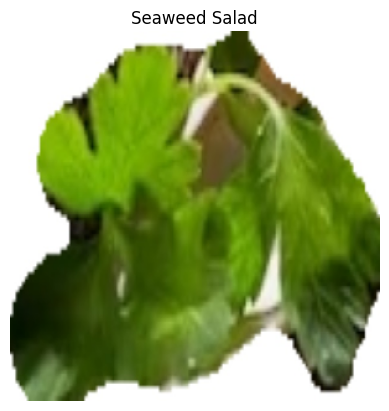

Food Name: Seaweed Salad
Serving weight in grams: 92.54
Amount Per Serving
	Calories: 106.37
	Total Fat: 7.26g
	Cholesterol: 0mg
	Sodium: 1143.64mg
	Potassium: 224.32mg
	Total Carbohydrates: 7.98g
	Sugars: 3.19g
	Protein: 2.9g
1/1 [==============================] - 0s 126ms/step


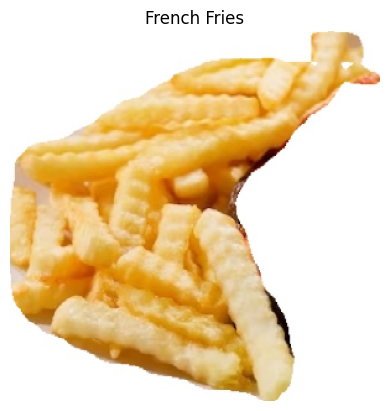

Food Name: French Fries
Serving weight in grams: 117
Amount Per Serving
	Calories: 365.04
	Total Fat: 17.23g
	Cholesterol: 0mg
	Sodium: 245.7mg
	Potassium: 677.43mg
	Total Carbohydrates: 48.48g
	Sugars: 0.35g
	Protein: 4.01g
1/1 [==============================] - 0s 124ms/step


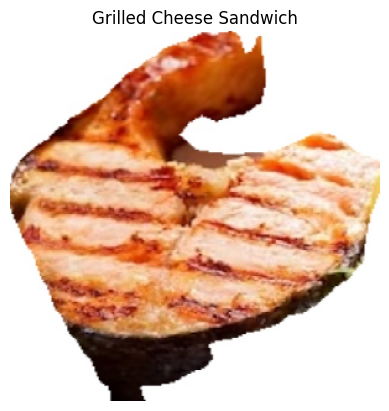

Food Name: Grilled Cheese Sandwich
Serving weight in grams: 106.19
Amount Per Serving
	Calories: 365.76
	Total Fat: 22.88g
	Cholesterol: 63.26mg
	Sodium: 886.01mg
	Potassium: 185.27mg
	Total Carbohydrates: 28.41g
	Sugars: 5.44g
	Protein: 11.74g
1/1 [==============================] - 0s 124ms/step


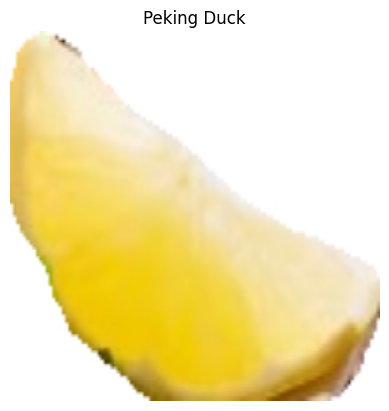

Food Name: Peking Duck
Serving weight in grams: 275.4
Amount Per Serving
	Calories: 662.64
	Total Fat: 41.48g
	Cholesterol: 118.1mg
	Sodium: 925.35mg
	Potassium: 526.77mg
	Total Carbohydrates: 42.35g
	Sugars: 29.42g
	Protein: 29.88g
1/1 [==============================] - 0s 125ms/step


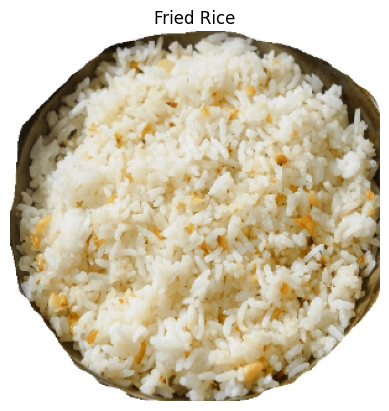

Food Name: Fried Rice
Serving weight in grams: 137
Amount Per Serving
	Calories: 238.38
	Total Fat: 4.06g
	Cholesterol: 24.66mg
	Sodium: 530.19mg
	Potassium: 104.12mg
	Total Carbohydrates: 44.92g
	Sugars: 0.77g
	Protein: 5.55g
1/1 [==============================] - 0s 127ms/step


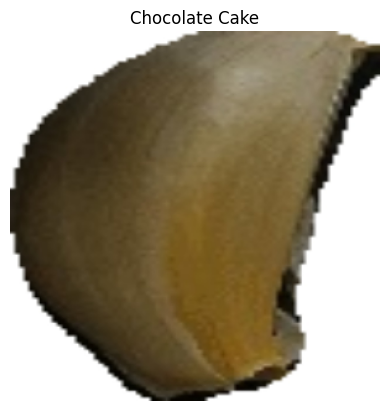

Food Name: Chocolate Cake
Serving weight in grams: 109
Amount Per Serving
	Calories: 424.01
	Total Fat: 21.85g
	Cholesterol: 23.98mg
	Sodium: 379.32mg
	Potassium: 294.3mg
	Total Carbohydrates: 57.6g
	Sugars: 43.56g
	Protein: 3.79g
1/1 [==============================] - 0s 121ms/step


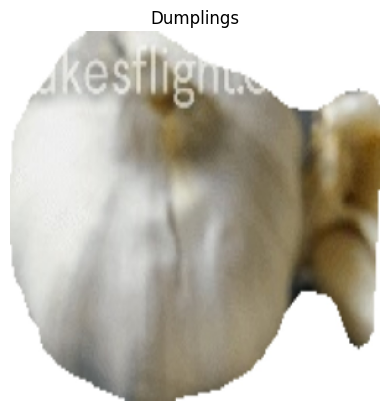

Food Name: Dumplings
Serving weight in grams: 32
Amount Per Serving
	Calories: 73.65
	Total Fat: 1.72g
	Cholesterol: 1.13mg
	Sodium: 270.88mg
	Potassium: 39.17mg
	Total Carbohydrates: 12.47g
	Sugars: 0.52g
	Protein: 1.99g
1/1 [==============================] - 0s 124ms/step


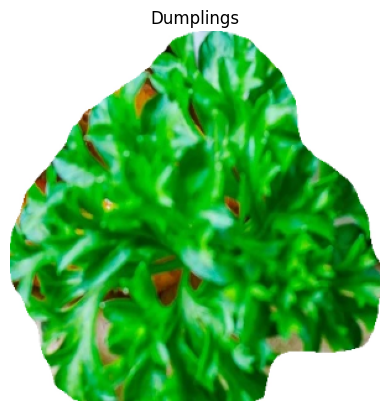

Food Name: Dumplings
Serving weight in grams: 32
Amount Per Serving
	Calories: 73.65
	Total Fat: 1.72g
	Cholesterol: 1.13mg
	Sodium: 270.88mg
	Potassium: 39.17mg
	Total Carbohydrates: 12.47g
	Sugars: 0.52g
	Protein: 1.99g
1/1 [==============================] - 0s 126ms/step


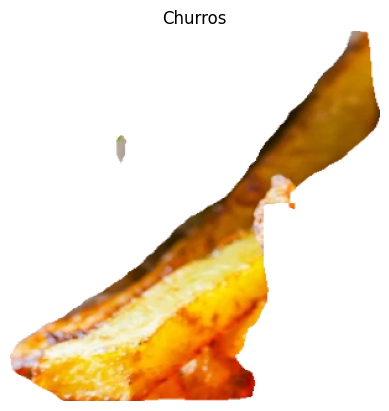

Food Name: Churros
Serving weight in grams: 26
Amount Per Serving
	Calories: 103.04
	Total Fat: 7.66g
	Cholesterol: 0mg
	Sodium: 43.71mg
	Potassium: 5.45mg
	Total Carbohydrates: 8.43g
	Sugars: 4.84g
	Protein: 0.48g
1/1 [==============================] - 0s 123ms/step


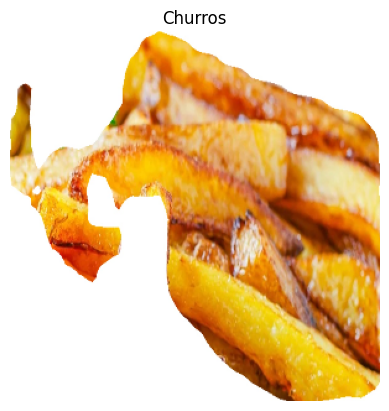

Food Name: Churros
Serving weight in grams: 26
Amount Per Serving
	Calories: 103.04
	Total Fat: 7.66g
	Cholesterol: 0mg
	Sodium: 43.71mg
	Potassium: 5.45mg
	Total Carbohydrates: 8.43g
	Sugars: 4.84g
	Protein: 0.48g
1/1 [==============================] - 0s 127ms/step


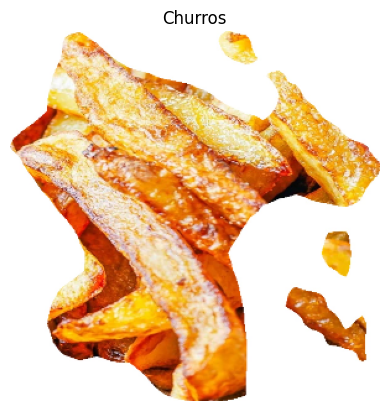

Food Name: Churros
Serving weight in grams: 26
Amount Per Serving
	Calories: 103.04
	Total Fat: 7.66g
	Cholesterol: 0mg
	Sodium: 43.71mg
	Potassium: 5.45mg
	Total Carbohydrates: 8.43g
	Sugars: 4.84g
	Protein: 0.48g
1/1 [==============================] - 0s 134ms/step


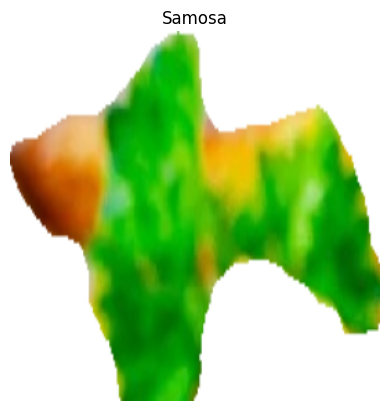

Food Name: Samosa
Serving weight in grams: 100
Amount Per Serving
	Calories: 261.5
	Total Fat: 17.24g
	Cholesterol: 27.48mg
	Sodium: 423.3mg
	Potassium: 189.09mg
	Total Carbohydrates: 23.91g
	Sugars: 1.59g
	Protein: 3.49g
1/1 [==============================] - 0s 126ms/step


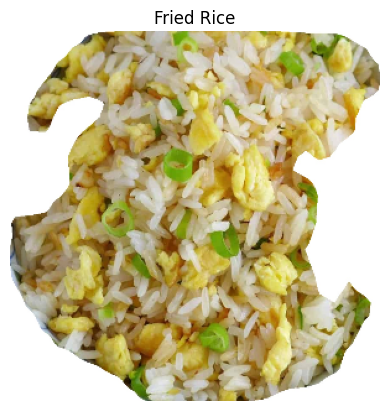

Food Name: Fried Rice
Serving weight in grams: 137
Amount Per Serving
	Calories: 238.38
	Total Fat: 4.06g
	Cholesterol: 24.66mg
	Sodium: 530.19mg
	Potassium: 104.12mg
	Total Carbohydrates: 44.92g
	Sugars: 0.77g
	Protein: 5.55g
1/1 [==============================] - 0s 135ms/step


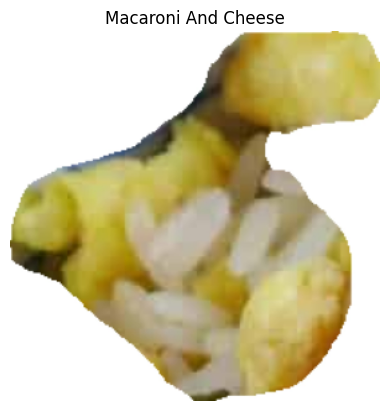

Food Name: Macaroni And Cheese
Serving weight in grams: 198
Amount Per Serving
	Calories: 376.2
	Total Fat: 16.39g
	Cholesterol: 5.94mg
	Sodium: 669.24mg
	Potassium: 255.42mg
	Total Carbohydrates: 47.38g
	Sugars: 8.45g
	Protein: 9.68g
1/1 [==============================] - 0s 131ms/step


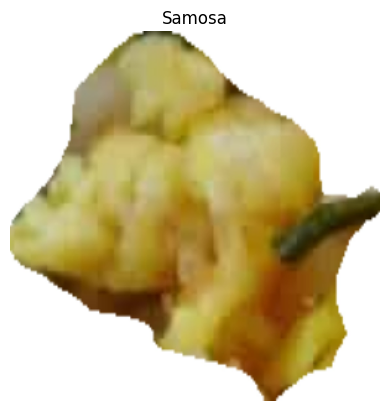

Food Name: Samosa
Serving weight in grams: 100
Amount Per Serving
	Calories: 261.5
	Total Fat: 17.24g
	Cholesterol: 27.48mg
	Sodium: 423.3mg
	Potassium: 189.09mg
	Total Carbohydrates: 23.91g
	Sugars: 1.59g
	Protein: 3.49g
1/1 [==============================] - 0s 124ms/step


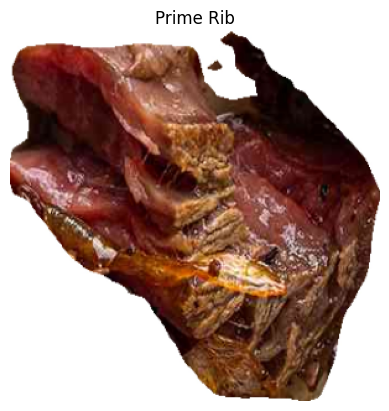

Food Name: Prime Rib
Serving weight in grams: 85
Amount Per Serving
	Calories: 289.85
	Total Fat: 23.07g
	Cholesterol: 70.55mg
	Sodium: 53.55mg
	Potassium: 275.4mg
	Total Carbohydrates: 0g
	Sugars: 0g
	Protein: 19.16g
1/1 [==============================] - 0s 145ms/step


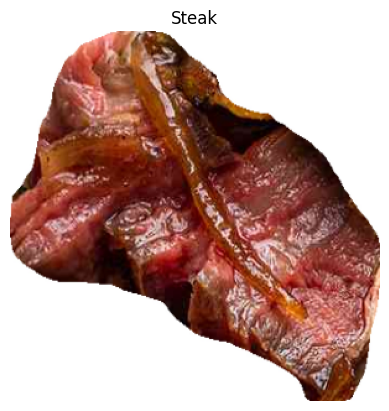

Food Name: Steak
Serving weight in grams: 221
Amount Per Serving
	Calories: 614.38
	Total Fat: 40.77g
	Cholesterol: 214.37mg
	Sodium: 114.92mg
	Potassium: 698.36mg
	Total Carbohydrates: 0g
	Sugars: 0g
	Protein: 57.81g
1/1 [==============================] - 0s 133ms/step


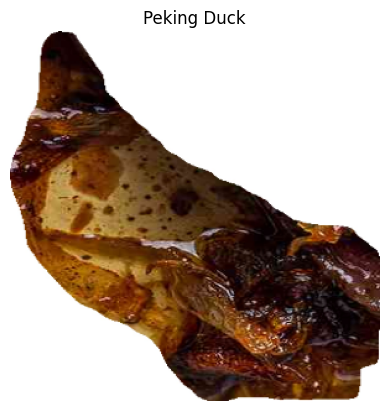

Food Name: Peking Duck
Serving weight in grams: 275.4
Amount Per Serving
	Calories: 662.64
	Total Fat: 41.48g
	Cholesterol: 118.1mg
	Sodium: 925.35mg
	Potassium: 526.77mg
	Total Carbohydrates: 42.35g
	Sugars: 29.42g
	Protein: 29.88g
1/1 [==============================] - 0s 125ms/step


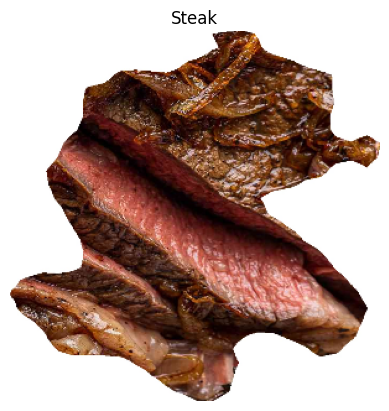

Food Name: Steak
Serving weight in grams: 221
Amount Per Serving
	Calories: 614.38
	Total Fat: 40.77g
	Cholesterol: 214.37mg
	Sodium: 114.92mg
	Potassium: 698.36mg
	Total Carbohydrates: 0g
	Sugars: 0g
	Protein: 57.81g


In [10]:
# Make a list of downloaded images and test the trained model
images = []
images.append('test_images/0.jpg')
images.append('test_images/1.jpg')
images.append('test_images/2.jpg')
images.append('test_images/3.jpg')
images.append('test_images/4.jpg')
images.append('test_images/5.jpg')
images.append('test_images/6.jpg')
images.append('test_images/7.jpg')
images.append('test_images/8.jpg')
images.append('test_images/9.jpg')
images.append('test_images/10.jpg')
images.append('test_images/11.jpg')
images.append('test_images/12.jpg')
images.append('test_images/13.jpg')
images.append('test_images/14.jpg')
images.append('test_images/15.jpg')
images.append('test_images/16.jpg')
images.append('test_images/17.jpg')
images.append('test_images/18.jpg')
#images.append('test_images/segmented_2.jpg')
#images.append('test_images/s.jpg')

predict_class(model_best, images, True)